In [1]:
#regular imports
import sys
import numpy as np
import pandas as pd
# Bring in some plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Setting up spark
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import *
from pyspark.sql.functions import *
conf = SparkConf().setMaster("local").setAppName("PySpark_feature_engineering")
spark = SparkSession.builder.getOrCreate()
print(spark)

In [3]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)

In [4]:
#check spark version
print(spark.version)

2.4.7


<h3> Read in some data </h3>



Here I'll be working through and expanding upon the course "Feature Engineering with Pyspark" by John Hogue, Lead Data Scientist at General Mills. The notebook considers feature engineering for the purpose of predicting the sale price on a subset of residential homes sold in 2017 in the city of St. Paul, MN. We'll download the data using pandas before converting it in to Spark. I do it this way for ease but at the cost of schema - Spark requires more attention to the type of individual columns and how missing values are handled. It isn't quite as versatile as pandas is in inferring data types from the data itself and literally can't handle having more than one data type in a single column. There is a built in method to attempt to infer a schema for the data types when none is provided, which we'll try out after converting all values in the pandas dataframe to strings.

In [5]:
# Download data into a pandas dataframe 
review_df = pd.read_csv('https://assets.datacamp.com/production/repositories/1704/datasets/d26c25f46746882d0a0f474cc6709c629f69872c/2017_StPaul_MN_Real_Estate.csv')

In [6]:
# Quickly run through the columns and change to strings to avoid the
# presence of different data types within columns - Spark complains if there are
o_type = review_df['MLSID'].dtypes
for column in review_df.columns:
    if review_df[column].dtype == o_type:
        review_df[column] = review_df[column].astype('str')

In [7]:
review_df['streetaddress'] = review_df['streetaddress'].astype('str')
review_df.dtypes # check your data types if desired

No.                      int64
MLSID                   object
StreetNumberNumeric      int64
streetaddress           object
STREETNAME              object
                        ...   
SQFTBELOWGROUND          int64
AssumableMortgage       object
AssociationFee           int64
ASSESSMENTPENDING       object
AssessedValuation      float64
Length: 74, dtype: object

In [8]:
# Setup a Spark SQL context and read in the pandas dataframe to a Spark dataframe
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

df = sqlContext.createDataFrame(review_df)

/Users/dur-rbaral-m/Downloads/spark-2.4.7-bin-hadoop2.7/python/pyspark/sql/session.py:714: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


In [9]:
# Need to convert some data types (since they were all converted to strings in the pandas df)
data_types = \
[('NO', 'bigint'),
 ('MLSID', 'string'),
 ('STREETNUMBERNUMERIC', 'bigint'),
 ('STREETADDRESS', 'string'),
 ('STREETNAME', 'string'),
 ('POSTALCODE', 'bigint'),
 ('STATEORPROVINCE', 'string'),
 ('CITY', 'string'),
 ('SALESCLOSEPRICE', 'bigint'),
 ('LISTDATE', 'timestamp'),
 ('LISTPRICE', 'bigint'),
 ('LISTTYPE', 'string'),
 ('ORIGINALLISTPRICE', 'bigint'),
 ('PRICEPERTSFT', 'double'),
 ('FOUNDATIONSIZE', 'bigint'),
 ('FENCE', 'string'),
 ('MAPLETTER', 'string'),
 ('LOTSIZEDIMENSIONS', 'string'),
 ('SCHOOLDISTRICTNUMBER', 'string'),
 ('DAYSONMARKET', 'bigint'),
 ('OFFMARKETDATE', 'timestamp'), # some columns are time-based values
 ('FIREPLACES', 'bigint'),
 ('ROOMAREA4', 'string'),
 ('ROOMTYPE', 'string'),
 ('ROOF', 'string'),
 ('ROOMFLOOR4', 'string'),
 ('POTENTIALSHORTSALE', 'string'),
 ('POOLDESCRIPTION', 'string'),
 ('PDOM', 'double'),
 ('GARAGEDESCRIPTION', 'string'),
 ('SQFTABOVEGROUND', 'bigint'),
 ('TAXES', 'bigint'),
 ('ROOMFLOOR1', 'string'),
 ('ROOMAREA1', 'string'),
 ('TAXWITHASSESSMENTS', 'double'),
 ('TAXYEAR', 'bigint'),
 ('LIVINGAREA', 'bigint'),
 ('UNITNUMBER', 'string'),
 ('YEARBUILT', 'bigint'),
 ('ZONING', 'string'),
 ('STYLE', 'string'),
 ('ACRES', 'double'),
 ('COOLINGDESCRIPTION', 'string'),
 ('APPLIANCES', 'string'),
 ('BACKONMARKETDATE', 'timestamp'),
 ('ROOMFAMILYCHAR', 'string'),
 ('ROOMAREA3', 'string'),
 ('EXTERIOR', 'string'),
 ('ROOMFLOOR3', 'string'),
 ('ROOMFLOOR2', 'string'),
 ('ROOMAREA2', 'string'),
 ('DININGROOMDESCRIPTION', 'string'),
 ('BASEMENT', 'string'),
 ('BATHSFULL', 'bigint'),
 ('BATHSHALF', 'bigint'),
 ('BATHQUARTER', 'bigint'),
 ('BATHSTHREEQUARTER', 'double'),
 ('CLASS', 'string'),
 ('BATHSTOTAL', 'bigint'),
 ('BATHDESC', 'string'),
 ('ROOMAREA5', 'string'),
 ('ROOMFLOOR5', 'string'),
 ('ROOMAREA6', 'string'),
 ('ROOMFLOOR6', 'string'),
 ('ROOMAREA7', 'string'),
 ('ROOMFLOOR7', 'string'),
 ('ROOMAREA8', 'string'),
 ('ROOMFLOOR8', 'string'),
 ('BEDROOMS', 'bigint'),
 ('SQFTBELOWGROUND', 'bigint'),
 ('ASSUMABLEMORTGAGE', 'string'),
 ('ASSOCIATIONFEE', 'bigint'),
 ('ASSESSMENTPENDING', 'string'),
 ('ASSESSEDVALUATION', 'double'),
 ('latitude', 'double'),
 ('longitude', 'double')]

In [10]:
# Correct all the column types
# .withColumn will be used heavily in this guide - it creates a new Spark 
# dataframe column, which can overwrite existing columns of the same name
df = df.withColumn("LISTDATE", to_timestamp("LISTDATE", "MM/dd/yyyy"))
df = df.withColumn("OFFMARKETDATE", to_timestamp("OFFMARKETDATE", "MM/dd/yyy"))
df = df.withColumn("AssessedValuation", df["AssessedValuation"].cast("double"))
df = df.withColumn("AssociationFee", df["AssociationFee"].cast("bigint"))
df = df.withColumn("SQFTBELOWGROUND", df["SQFTBELOWGROUND"].cast("bigint"))
df = df.withColumn("Bedrooms", df["Bedrooms"].cast("bigint"))
df = df.withColumn("BATHSTOTAL", df["BATHSTOTAL"].cast("bigint"))
df = df.withColumn("BATHSTHREEQUARTER", df["BATHSTHREEQUARTER"].cast("double"))
df = df.withColumn("BATHQUARTER", df["BATHQUARTER"].cast("bigint"))
df = df.withColumn("BathsHalf", df["BathsHalf"].cast("bigint"))
df = df.withColumn("BathsFull", df["BathsFull"].cast("bigint"))
df = df.withColumn("backonmarketdate", df["backonmarketdate"].cast("double"))
df = df.withColumn("ACRES", df["ACRES"].cast("double"))
df = df.withColumn("YEARBUILT", df["YEARBUILT"].cast("bigint"))
df = df.withColumn("LivingArea", df["LivingArea"].cast("bigint"))
df = df.withColumn("TAXYEAR", df["TAXYEAR"].cast("bigint"))
df = df.withColumn("TAXWITHASSESSMENTS", df["TAXWITHASSESSMENTS"].cast("double"))
df = df.withColumn("Taxes", df["Taxes"].cast("bigint"))
df = df.withColumn("SQFTABOVEGROUND", df["SQFTABOVEGROUND"].cast("bigint"))
df = df.withColumn("PDOM", df["PDOM"].cast("bigint"))
df = df.withColumn("Fireplaces", df["Fireplaces"].cast("bigint"))
df = df.withColumn("FOUNDATIONSIZE", df["FOUNDATIONSIZE"].cast("bigint"))
df = df.withColumn("PricePerTSFT", df["PricePerTSFT"].cast("double"))
df = df.withColumn("OriginalListPrice", df["OriginalListPrice"].cast("bigint"))
df = df.withColumn("LISTPRICE", df["OriginalListPrice"].cast("bigint"))
df = df.withColumn("SalesClosePrice", df["SalesClosePrice"].cast("bigint"))
df = df.withColumn("PostalCode", df["PostalCode"].cast("bigint"))
#df = df.withColumn("No.", df["No."].cast("bigint"))

In [11]:
# Drop the No. column, Spark is very unhappy with the '.' in this column name - this will be rectified later on
df = df.drop('No.')

<h3>Basic Summary Stats</h3>

Shape

In [12]:
print(df.count(), len(df.columns))

5000 73


In [13]:
#describe a col
df[["SalesClosePrice"]].describe().show()
# note the double bracket col indexing and 
# the .show() to force Spark to run the job

+-------+------------------+
|summary|   SalesClosePrice|
+-------+------------------+
|  count|              5000|
|   mean|       262804.4668|
| stddev|140559.82591998554|
|    min|             48000|
|    max|           1700000|
+-------+------------------+



In [14]:
# Or multiple columns
df.select(['LISTPRICE', 'Taxes', 'SQFTABOVEGROUND', 'FOUNDATIONSIZE', 'Fireplaces']).describe().show()

+-------+------------------+----------------+-----------------+-----------------+------------------+
|summary|         LISTPRICE|           Taxes|  SQFTABOVEGROUND|   FOUNDATIONSIZE|        Fireplaces|
+-------+------------------+----------------+-----------------+-----------------+------------------+
|  count|              5000|            5000|             5000|             5000|              5000|
|   mean|       275002.6304|       3373.6548|         1489.013|        1016.4118|            0.5848|
| stddev|409620.68253253616|36040.6982804627|626.4868033517989|339.2604052129706|0.7088790178107817|
|    min|                 5|               0|                1|                1|                 0|
|    max|          21990000|         2547070|             7200|             3792|                 8|
+-------+------------------+----------------+-----------------+-----------------+------------------+



In [15]:
# Covariance 
# Covariance is a measure of how two variables change with respect to each other. 
# A positive number would mean that there is a tendency that as one variable increases, 
# the other increases as well. A negative number would mean that as one variable increases, 
# the other variable has a tendency to decrease. The sample covariance of two columns of a 
# DataFrame can be calculated as follows:

print(df.cov('SalesClosePrice', 'YEARBUILT'))
# or
print(df.stat.cov('SalesClosePrice', 'YEARBUILT'))

1281910.384063521
1281910.3840635198


In [16]:
# Correlation is perhaps more straightforward to interpret
# Correlation is a normalized measure of covariance that is easier to understand, 
# as it provides quantitative measurements of the statistical dependence between two random variables.

print(df.corr('SalesClosePrice', 'YEARBUILT'))
print(df.stat.corr('SalesClosePrice', 'YEARBUILT'))

0.2347514203250753
0.2347514203250753


In [19]:
# Perform an aggregation function
print("Average sales price: ${}".format(df.agg({'SalesClosePrice': 'mean'}).collect()[0][0]))
print("Standard deviation of sales prices: ${}".format(df.agg({'SalesClosePrice': 'stddev'}).collect()[0][0]))
print("Max sales price: ${}".format(df.agg({'SalesClosePrice': 'max'}).collect()[0][0]))
print("Min sale price: ${}".format(df.agg({'SalesClosePrice': 'min'}).collect()[0][0]))

Average sales price: $262804.4668
Standard deviation of sales prices: $140559.82591998554
Max sales price: $1700000
Min sale price: $48000


<h3> Visual inspection through linear models and distribution skew </h3>

In [22]:
# Sample spark df and plot 
# It's a best practice to sample data from your Spark df into pandas so as to not asplode your machine's memory
# Remember, the idea is to use Spark for data that is too large to fit in your machine's memory
s_df = df.select(['SalesClosePrice', 'YEARBUILT']).sample(withReplacement=False, fraction=0.5, seed=42)

# Create a Pandas df from a subset of columns, those that are sampled
s_df_pandas = s_df.toPandas() 

# Or the entire Spark df
df_pandas = df.toPandas()

/usr/local/opt/apache-spark/libexec/python/pyspark/sql/dataframe.py:2110: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


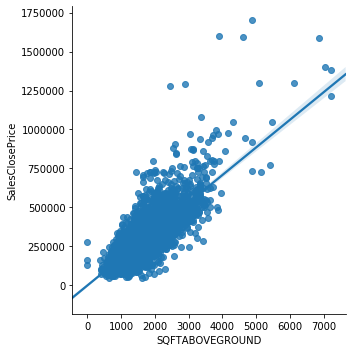

In [23]:
# A basic seaborn linear model plot
sns.lmplot(y = 'SalesClosePrice', x = 'SQFTABOVEGROUND', data=df_pandas)

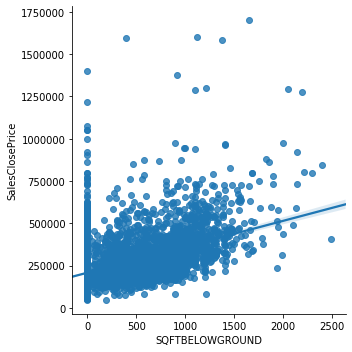

In [24]:
sns.lmplot(y = 'SalesClosePrice', x = 'SQFTBELOWGROUND', data=df_pandas)

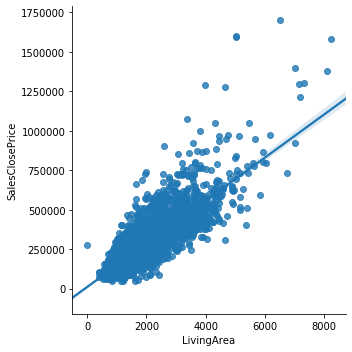

In [25]:
sns.lmplot(y = 'SalesClosePrice', x = 'LivingArea', data=df_pandas)

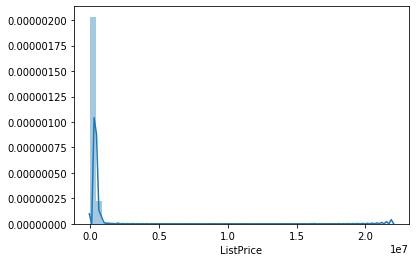

In [26]:
# Plot distribution of pandas_df features
# Select a single column and sample and convert to pandas
sample_df = df.select(['LISTPRICE']).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)
plt.xlabel('ListPrice') 
plt.show()

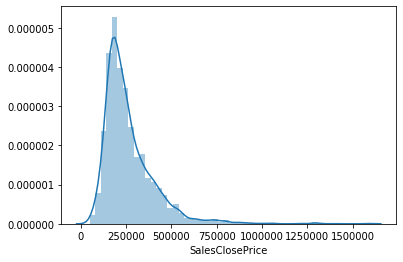

In [27]:
# Plot distribution of pandas_df and display plot
# Select a single column and sample and convert to pandas
sample_df = df.select(['SalesClosePrice']).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)
plt.xlabel('SalesClosePrice') 
plt.show()

In [28]:
print(df.corr('SalesClosePrice', 'LivingArea'))
print(df.corr('SalesClosePrice', 'SQFTABOVEGROUND'))

0.8162701823275658
0.7901878498502953


In [29]:
#Filtering based on values of text
# Filter by values - expensive homes
df.where(df['SalesClosePrice'] > 1000000)[['SalesClosePrice']].show(10)

+---------------+
|SalesClosePrice|
+---------------+
|        1277023|
|        1050000|
|        1290000|
|        1295000|
|        1215000|
|        1380000|
|        1300000|
|        1400000|
|        1595000|
|        1600000|
+---------------+
only showing top 10 rows



In [30]:
# Filter by values - cheap homes
df.where(df['SalesClosePrice'] < 100000)[['SalesClosePrice']].show(10)

+---------------+
|SalesClosePrice|
+---------------+
|          90000|
|          94900|
|          79900|
|          78000|
|          99000|
|          80000|
|          48000|
|          49900|
|          80004|
|          50800|
+---------------+
only showing top 10 rows



In [31]:
# Porque no los dos? (Why not both?)
# Note that I'm using .filter() here - there is no difference b/t .where and .filter -
# .where is provided for those who are used to the SQL implementation of WHERE, 
# while .filter is provided for the Scala familiar
df.filter((df['SalesClosePrice'] < 100000) | 
          (df['SalesClosePrice'] > 1000000))[['SalesClosePrice']].describe().show()

+-------+------------------+
|summary|   SalesClosePrice|
+-------+------------------+
|  count|               128|
|   mean|    220585.4921875|
| stddev|401209.07209677587|
|    min|             48000|
|    max|           1700000|
+-------+------------------+



In [36]:
# What if you really don't like metal roofs and have a huge budget?
# There are some missing values here, we'll show how to deal with those below
df.where((df['ROOF'] != 'Metal') &
          (df['SalesClosePrice'] > 1000000))[['SalesClosePrice', 'ROOF']].show(truncate=50)

+---------------+-------------------------------------------+
|SalesClosePrice|                                       ROOF|
+---------------+-------------------------------------------+
|        1277023|                                        nan|
|        1050000|                                        nan|
|        1290000|                           Asphalt Shingles|
|        1295000|Asphalt Shingles, Pitched, Age Over 8 Years|
|        1215000|                           Asphalt Shingles|
|        1380000|                                        nan|
|        1300000|                           Asphalt Shingles|
|        1400000|              Age Over 8 Years, Tile, Metal|
|        1595000|      Asphalt Shingles, Age 8 Years or Less|
|        1600000|                                     Shakes|
|        1700000|                                        nan|
|        1585000|                                      Slate|
|        1050216|      Asphalt Shingles, Age 8 Years or Less|
|       

In [37]:
# More value filtering, this time with aggregation functions
std_val = df.agg({'SalesClosePrice': 'stddev'}).collect()[0][0]
mean_val = df.agg({'SalesClosePrice': 'mean'}).collect()[0][0]

# Setup values for dropping outliers that are 3 standard deviations from the mean
hi_bound = mean_val + (3 * std_val)
low_bound = mean_val - (3 * std_val)

df.where((df['LISTPRICE'] < hi_bound) & (df['LISTPRICE'] > low_bound)).count() # Here we dropped 91 observations

4909

In [39]:
# Filter based on text 

# Inspect unique values in the column 'ASSUMABLEMORTGAGE'
print(df.select(['ASSUMABLEMORTGAGE']).distinct().show())

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|                nan|
|Yes w/No Qualifying|
|      Not Assumable|
+-------------------+

None


In [40]:
# List of possible values containing 'yes'
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

# Filter the text values out of df but keep null values (good use of that ~ here)
text_filter = ~df['ASSUMABLEMORTGAGE'].isin(yes_values) | df['ASSUMABLEMORTGAGE'].isNull()
df.where(text_filter).count()

4976

In [41]:
# Text filtering - where the cooling description is NOT (via the ~) central air
df.where(~df['CoolingDescription'].like('Central'))[['CoolingDescription']].show(5)

+------------------+
|CoolingDescription|
+------------------+
|            Window|
|              None|
|              None|
|       Geothermal |
|              None|
+------------------+
only showing top 5 rows



<h3>Dropping NA values or dropping columns outright</h3>

See the Missing Values chunks below for a more sophisticated approach to dropping NA or NaN values.

In [42]:
# Remove rows with any NA values - naive approach
df.dropna().count() #oops, one column is all missing and that drops the whole dataset

0

In [43]:
# Remove a record if it has NA values in three columns
df.dropna(thresh=3).count() # we don't have any missing values aside from one column, which is nice

5000

In [44]:
# Make a list of columns to drop
cols_to_drop = ['No.', 'UNITNUMBER', 'CLASS']

# Drop the columns 
df = df.drop(*cols_to_drop) # the star (*) tells the function to unpack the list and drop them one-by-one

<h3> Transforming or Adjusting Data </h3>

MinMax Scaling, Standardizing (z-score transformation), Log Scaling
"Data does not give up its secrets easily, it must be tortured to confess"


<h4> MinMax Scaling </h4>

In [45]:
# define the minimum and maximum values for the feature of interest
min_val = df.agg({'SQFTABOVEGROUND':'min'}).collect()[0][0] # collect forces the agg func to run
max_val = df.agg({'SQFTABOVEGROUND':'max'}).collect()[0][0] # [0][0] is necessary to return the value

In [46]:
# Now use the values to create a new column from the scaled data
# the withColumn() method creates a new column based on a transformation of another column
df.withColumn('scaled_SQFTABOVE', (df['SQFTABOVEGROUND'] - min_val)/(max_val - min_val))[['scaled_SQFTABOVE']].show(5)


+-------------------+
|   scaled_SQFTABOVE|
+-------------------+
|0.13599110987637172|
| 0.1759966662036394|
|0.15293790804278373|
|0.17821919711070983|
| 0.1423808862341992|
+-------------------+
only showing top 5 rows



In [47]:
# How about we make a custom function to scale columns of our choice
def min_max_scaler(df, cols_to_scale):
  # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
  for col in cols_to_scale:
    # Define min and max values and collect them
    max_days = df.agg({col: 'max'}).collect()[0][0]
    min_days = df.agg({col: 'min'}).collect()[0][0]
    new_column_name = 'scaled_' + col
    # Create a new column based off the scaled data
    df = df.withColumn(new_column_name, 
                      (df[col] - min_days) / (max_days - min_days))
  return df

cols_to_scale = ['SQFTABOVEGROUND', 'LISTPRICE', 'DAYSONMARKET']

min_max_scaler(df, cols_to_scale)[['SQFTABOVEGROUND','scaled_SQFTABOVEGROUND', 
                                   'LISTPRICE', 'scaled_LISTPRICE', 
                                   'DAYSONMARKET', 'scaled_DAYSONMARKET']].show(5)

+---------------+----------------------+---------+--------------------+------------+--------------------+
|SQFTABOVEGROUND|scaled_SQFTABOVEGROUND|LISTPRICE|    scaled_LISTPRICE|DAYSONMARKET| scaled_DAYSONMARKET|
+---------------+----------------------+---------+--------------------+------------+--------------------+
|            980|   0.13599110987637172|   139900|0.006361756789849202|          10|0.044444444444444446|
|           1268|    0.1759966662036394|   210000|0.009549570156791759|           4|0.017777777777777778|
|           1102|   0.15293790804278373|   225000| 0.01023169855200058|          28| 0.12444444444444444|
|           1284|   0.17821919711070983|   230000|0.010459074683736854|          19| 0.08444444444444445|
|           1026|    0.1423808862341992|   239900|0.010909279424574677|          21| 0.09333333333333334|
+---------------+----------------------+---------+--------------------+------------+--------------------+
only showing top 5 rows



<h3> Standardaizing </h3>

In [48]:
# Similar process to MinMax, but the focus here is on the distribution of the data as opposed to its range of values
# define the mean and std values for the feature of interest
mean_val = df.agg({'SQFTABOVEGROUND':'mean'}).collect()[0][0] # collect forces the agg func to run
std_val = df.agg({'SQFTABOVEGROUND':'stddev'}).collect()[0][0]

# Create new column with standardized data
df_stand = df.withColumn('standardized_SQFTABOVE', (df['SQFTABOVEGROUND'] - mean_val)/std_val)[['standardized_SQFTABOVE']]

# Check the mean to be close to 0 
print(df_stand.agg({'standardized_SQFTABOVE': 'mean'}).collect()[0][0])

# And the stddev to be close to 1
print(df_stand.agg({'standardized_SQFTABOVE': 'stddev'}).collect()) # I left out the [0][0] to show what you'd see otherwise

4.5474735088646414e-17
[Row(stddev(standardized_SQFTABOVE)=0.999999999999999)]


<h3> Log Transformation </h3>

In [50]:
from pyspark.sql.functions import log

# First check skewness
print(df.agg({'LISTPRICE': 'skewness'}).collect()[0][0])

df.withColumn('logged_ListPrice', log(df['LISTPRICE']))[['logged_ListPrice']].show(4)

41.754097861397526
+------------------+
|  logged_ListPrice|
+------------------+
|11.848683160653573|
|12.254862809699606|
|12.323855681186558|
|12.345834587905333|
+------------------+
only showing top 4 rows



In [51]:
# Another approach to wrangle a skewed feature into something that's more normally distributed

# Compute the skewness
print(df.agg({'YEARBUILT': 'skewness'}).collect())

# Calculate the max year
max_year = df.agg({'YEARBUILT': 'max'}).collect()[0][0]

# Create a new column of reflected data
df_reflect = df.withColumn('Reflect_YearBuilt', (max_year + 1) - df['YEARBUILT'])

# Create a new column based reflected data
df_reflect.withColumn('adj_yearbuilt', 1 / log(df_reflect['Reflect_YearBuilt']))[['YEARBUILT', 'Reflect_YearBuilt', 'adj_yearbuilt']].show(5)

[Row(skewness(YEARBUILT)=-0.2455425013492753)]
+---------+-----------------+-------------------+
|YEARBUILT|Reflect_YearBuilt|      adj_yearbuilt|
+---------+-----------------+-------------------+
|     1950|               69|0.23617733727628992|
|     1971|               48|0.25831776680732876|
|     1949|               70|0.23537745555238682|
|     1960|               59| 0.2452460618098304|
|     1978|               41|  0.269282508064391|
+---------+-----------------+-------------------+
only showing top 5 rows



<h3> Missing Values </h3>

<h4> Acessing missingness </h4>

A heatmap from seaborn is a good way to determine the extent of missing data in a dataset.


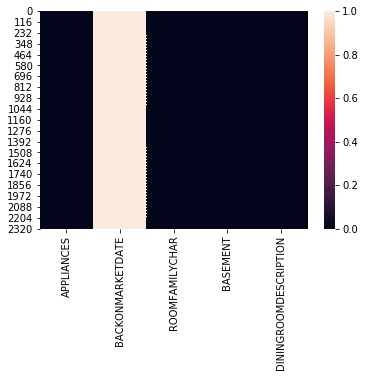

In [52]:
columns = ['APPLIANCES','BACKONMARKETDATE','ROOMFAMILYCHAR', 'BASEMENT','DININGROOMDESCRIPTION']
# Sample the dataframe and convert to Pandas
sample_df = df.select(columns).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Convert all values to T/F
tf_df = pandas_df.isnull()

# Plot it
sns.heatmap(data=tf_df)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

In [53]:
#imputation
# Count missing rows
missing = df.where(df['PDOM'].isNull()).count()

# Calculate the mean value
col_mean = df.agg({'PDOM': 'mean'}).collect()[0][0]

# Replacing with the mean value for that column
df.fillna(col_mean, subset=['PDOM'])[['PDOM']].show(5)

+----+
|PDOM|
+----+
|  10|
|   4|
|  28|
|  19|
|  21|
+----+
only showing top 5 rows



<h3> Dropping columns by a threshold of percent missing (null) or percent NaN </h3>

In [54]:
# Define a function to drop columns if they meet a threshold of missingness or NaNness
# Note: this won't work on timestamp or date type columns

# Drop the timestamp columns
df_no_dates = df.select([c for c in df.columns if c not in {'LISTDATE', 'OFFMARKETDATE'}])

# Could also do:
#df.drop('LISTDATE', 'OFFMARKETDATE')

def column_dropper(df, threshold = 0.60):
  # Takes a dataframe and threshold for missing values. Returns a dataframe.
  total_records = df.count()
  for col in df.columns:
    # Calculate the percentage of missing values
    missing_null = df.where(df[col].isNull()).count()
    missing_nan = df.where(isnan(df[col])).count()
    missing_percent_null = missing_null / total_records
    missing_percent_nan = missing_nan / total_records
    # Drop column if percent of missing is more than threshold
    if (missing_percent_null > threshold) | (missing_percent_nan > threshold):
      df = df.drop(col)
  return df

# Drop columns that are more than 60% missing
len(column_dropper(df_no_dates, 0.60).columns)

68

<h3> Joining data in Spark with PySpark or with SparkSQL </h3>

In [55]:
# Joining with PySpark

# Convert sqft to sqm (square meters) and select the street address and sqm living area size for a new df
LivingArea_sqm = df.withColumn('LivingArea_sqm', df['LivingArea'] / 10.764)[['streetaddress', 'LivingArea_sqm']]

# Create join condition - here we are joining on the same column ('streetaddress')
# But in instances where the join is on columns of different names, you need to 
# create a join condition to join on, such as:
### condition = [df['SalesClosePrice'] == LivingArea_sqm['SalesClosePrice']]

# Join the dataframes together
join_df = df.join(LivingArea_sqm, on=['streetaddress'], how='left')

# Count non-null records from new field
join_df.select(['streetaddress', 'LivingArea', 'LivingArea_sqm', 'SalesClosePrice']).show(10)

# Certainly, the size of the living area in a house is likely going to be a major predictor of its sale price

+--------------------+----------+------------------+---------------+
|       streetaddress|LivingArea|    LivingArea_sqm|SalesClosePrice|
+--------------------+----------+------------------+---------------+
|      1107 Jenks Ave|      1088|101.07766629505761|         172500|
|1181 Edgcumbe Rd,...|       720| 66.88963210702342|          62000|
|      1485 Blair Ave|      1932| 179.4871794871795|         241350|
|       1679 Lark Ave|      1610| 149.5726495726496|         180000|
|  2014 Worcester Ave|      1638|152.17391304347828|         295000|
|     2338 Bourne Ave|      2352|218.50613154960982|         480000|
|2371 Mailand Ct E...|      1381|128.29803047194352|         151000|
|2439 Springside Dr E|      3142|291.89892233370495|         440000|
|   26 10th St W, 410|      1073| 99.68413229282795|         156000|
|2645 New Century ...|      1598|148.45782237086587|         215000|
+--------------------+----------+------------------+---------------+
only showing top 10 rows



In [56]:
# Joining data with Spark SQL

# You have to be VERY careful so as not to duplicate columns when using a SQL join.
# Spark doesn't work as intuitively as you might think in this area. Notice the 
# aliasing in the SELECT statement below - if a * was used, the joined_df table
# will end up with two 'streetaddress' columns and Spark isn't able to distinguish
# between them because they have the same name (even though they don't really, but 
# that's a different story. This behavior was fixed in the above join via the use 
# of [] or "" around the column name being joined on, but it persists in the SQL
# join methodology below unless you specifically call for only one of the columns being 
# joined on in the SELECT statement. 

# Register dataframes as tables
df.createOrReplaceTempView('df')
LivingArea_sqm.createOrReplaceTempView('LivingArea_sqm')

# SQL to join dataframes
join_sql = 	"""
			SELECT df.streetaddress, df.LivingArea, LivingArea_sqm
			FROM df
			LEFT JOIN LivingArea_sqm
			ON df.streetaddress = LivingArea_sqm.streetaddress
			"""

# Perform sql join
joined_df = spark.sql(join_sql)

joined_df.show(10)

+--------------------+----------+------------------+
|       streetaddress|LivingArea|    LivingArea_sqm|
+--------------------+----------+------------------+
|      1107 Jenks Ave|      1088|101.07766629505761|
|1181 Edgcumbe Rd,...|       720| 66.88963210702342|
|      1485 Blair Ave|      1932| 179.4871794871795|
|       1679 Lark Ave|      1610| 149.5726495726496|
|  2014 Worcester Ave|      1638|152.17391304347828|
|     2338 Bourne Ave|      2352|218.50613154960982|
|2371 Mailand Ct E...|      1381|128.29803047194352|
|2439 Springside Dr E|      3142|291.89892233370495|
|   26 10th St W, 410|      1073| 99.68413229282795|
|2645 New Century ...|      1598|148.45782237086587|
+--------------------+----------+------------------+
only showing top 10 rows



<h3> Basic Feature Engineering </h3>


At the most basic level, feature engineering involves combining two or more known features into new features using simple arithmetic operations. In our running example of home prices, you might have features for the square footage of a home both above ground and below ground that you can sum into a new, total square footage feature (total_sqft). Then, it is possible to make yet another new feature, price_per_sqft by taking total_sqft/list_price. Combining price_per_sqft with another existing or newly created feature can often make things difficult to interpret, so unless there's a good reason to do so it's usually best to stop at combinations of three columns.
It's also a good idea to keep the number of columns down to reasonable levels (i.e. it's not usually productive to add the pairwise multiplication of each feature and every other feature).
There are two great packages that help to implement feature engineering and are worth looking into - <a href="https://tsfresh.readthedocs.io/en/latest/text/quick_start.html">tsfresh</a> and <a href="https://docs.featuretools.com/index.html">Featuretools</a>.

In [57]:
# Lot size in square feet
acres_to_sqfeet = 43560
df = df.withColumn('LOT_SIZE_SQFT', df['ACRES'] * acres_to_sqfeet)

# Create new column YARD_SIZE
df = df.withColumn('YARD_SIZE', df['LOT_SIZE_SQFT'] - df['FOUNDATIONSIZE'])

# Corr of ACRES vs SALESCLOSEPRICE
print("Corr of ACRES vs SalesClosePrice: " + str(df.corr('ACRES', 'SalesClosePrice')))
# Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE
print("Corr of FOUNDATIONSIZE vs SalesClosePrice: " + str(df.corr('FOUNDATIONSIZE', 'SalesClosePrice')))
# Corr of YARD_SIZE vs SALESCLOSEPRICE
print("Corr of YARD_SIZE vs SalesClosePrice: " + str(df.corr('YARD_SIZE', 'SalesClosePrice')))

Corr of ACRES vs SalesClosePrice: 0.22060612588935322
Corr of FOUNDATIONSIZE vs SalesClosePrice: 0.6152231695664411
Corr of YARD_SIZE vs SalesClosePrice: 0.2071458543085424


In [65]:
# Create feature Ratios

# ASSESSED_TO_LIST
df = df.withColumn('ASSESSED_TO_LIST', df['AssessedValuation']/df['LISTPRICE'])
df[['AssessedValuation', 'LISTPRICE', 'ASSESSED_TO_LIST']]\
                .sort(col('ASSESSED_TO_LIST').desc()).show(5) # a home for $5?! Either a mistake or family transfer

# TAX_TO_LIST
df = df.withColumn('TAX_TO_LIST', df['TAXES']/df['LISTPRICE'])
df[['TAX_TO_LIST', 'TAXES', 'LISTPRICE']].sort(col('TAXES').desc()).show(5) # Looks like we got a big outlier here

# BED_TO_BATHS
df = df.withColumn('BED_TO_BATHS', df['BEDROOMS']/df['BATHSTOTAL'])
df[['BED_TO_BATHS', 'BEDROOMS', 'BATHSTOTAL']].sort(col('BED_TO_BATHS').desc()).show(5) 
# Maybe a more sensitive feature would be baths to beds based on the data below

+-----------------+---------+--------------------+
|AssessedValuation|LISTPRICE|    ASSESSED_TO_LIST|
+-----------------+---------+--------------------+
|            255.0|        5|                51.0|
|           2861.0|    40000|            0.071525|
|           8588.0|   164900| 0.05208004851425106|
|           9090.0|   189900|0.047867298578199054|
|           6600.0|   150000|               0.044|
+-----------------+---------+--------------------+
only showing top 5 rows

+--------------------+-------+---------+
|         TAX_TO_LIST|  TAXES|LISTPRICE|
+--------------------+-------+---------+
|   8.786029665401863|2547070|   289900|
| 0.02541769451296753|  38124|  1499900|
|0.022931159420289855|  31645|  1380000|
|0.018127058823529413|  30816|  1700000|
|0.019410033444816052|  29018|  1495000|
+--------------------+-------+---------+
only showing top 5 rows

+------------+--------+----------+
|BED_TO_BATHS|BEDROOMS|BATHSTOTAL|
+------------+--------+----------+
|         5.0|   

+-------+-----------------+------------------+-------------------+
|summary|       Total_SQFT|        BATHSTOTAL| BATHS_PER_1000SQFT|
+-------+-----------------+------------------+-------------------+
|  count|             5000|              5000|               5000|
|   mean|         1844.528|            2.2008| 1.4302617483739897|
| stddev|840.4421899398709|0.9574250323333457|  14.12890410245937|
|    min|                1|                 1|0.39123630672926446|
|    max|             8222|                 7|             1000.0|
+-------+-----------------+------------------+-------------------+

+----------+----------+------------------+
|Total_SQFT|BATHSTOTAL|BATHS_PER_1000SQFT|
+----------+----------+------------------+
|         1|         1|            1000.0|
|       934|         4| 4.282655246252676|
|       600|         2|3.3333333333333335|
|       649|         2| 3.081664098613251|
|      1047|         3| 2.865329512893983|
+----------+----------+------------------+
only show

/Users/dur-rbaral-m/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


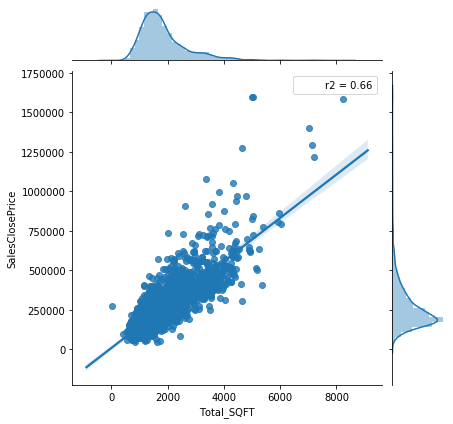

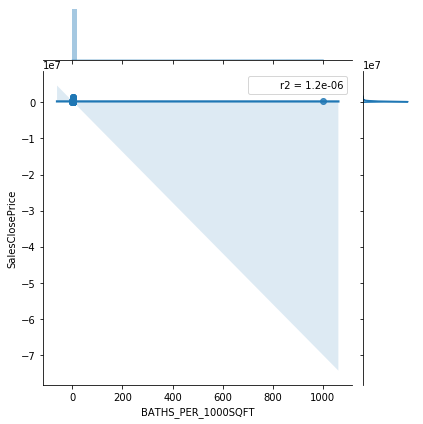

In [66]:
# Create new feature by adding two features together
df = df.withColumn('Total_SQFT', df['SQFTBELOWGROUND'] + df['SQFTABOVEGROUND'])

# Create additional new feature using previously created feature
df = df.withColumn('BATHS_PER_1000SQFT', df['BATHSTOTAL'] / (df['Total_SQFT'] / 1000))
df[['Total_SQFT','BATHSTOTAL','BATHS_PER_1000SQFT']].describe().show() # clearly have an outlier

# Check on outlier - a house that is 1 sqft would be a little tight, but at least it has a bathroom
df[['Total_SQFT','BATHSTOTAL','BATHS_PER_1000SQFT']].sort(col('BATHS_PER_1000SQFT').desc()).show(5)

# Sample and create pandas dataframe
pandas_df = df.sample(False, 0.5, 0).toPandas()

import scipy.stats as stats

# Define a function to compute r^2
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

# Linear model plots
sns.jointplot(x='Total_SQFT', y='SalesClosePrice', data=pandas_df, kind="reg", stat_func=r2)
plt.show()
sns.jointplot(x='BATHS_PER_1000SQFT', y='SalesClosePrice', data=pandas_df, kind="reg",stat_func=r2) 
plt.show() # Clearly have an outlier here

<h3> Time Components </h3>

Time is cyclical and creating new features based on time can be very influential if done well. PySpark's week starts on Sunday, with a value of 1 and ends on Saturday, a value of 7.

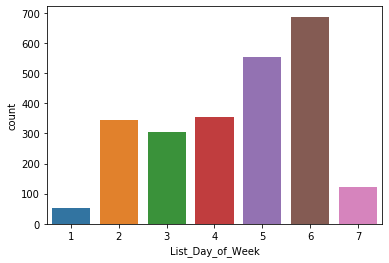

In [67]:
# Import needed functions
from pyspark.sql.functions import to_date, dayofweek

# Convert to date type
df = df.withColumn('LISTDATE', to_date('LISTDATE')) # note that this was in timestamp format, 
                                                    # to_date doesn't work on strings

# Get the day of the week
df = df.withColumn('List_Day_of_Week', dayofweek('LISTDATE'))

# Sample and convert to pandas dataframe
sample_df = df.sample(False, .5, 42).toPandas()

# Plot count plot of of day of week - most houses are listed on Thursdays and Fridays in this dataset it seems
sns.countplot(x="List_Day_of_Week", data=sample_df)
plt.show()

In [68]:
# Let's pull individual components of the timestamp feature we have as separate features

# Import needed functions
from pyspark.sql.functions import year, month, dayofmonth, weekofyear

print(df.withColumn('Year', year('LISTDATE'))[['Year']].show(5))
print(df.withColumn('Month', month('LISTDATE'))[['Month']].show(5))
print(df.withColumn('DayofMonth', dayofmonth('LISTDATE'))[['DayofMonth']].show(5))
print(df.withColumn('WeekofYear', weekofyear('LISTDATE'))[['WeekofYear']].show(5))

+----+
|Year|
+----+
|2017|
|2017|
|2017|
|2017|
|2017|
+----+
only showing top 5 rows

None
+-----+
|Month|
+-----+
|    7|
|   10|
|    6|
|    8|
|    9|
+-----+
only showing top 5 rows

None
+----------+
|DayofMonth|
+----------+
|        15|
|         9|
|        26|
|        25|
|        12|
+----------+
only showing top 5 rows

None
+----------+
|WeekofYear|
+----------+
|        28|
|        41|
|        26|
|        34|
|        37|
+----------+
only showing top 5 rows

None


In [69]:
from pyspark.sql.functions import lag, datediff, to_date
from pyspark.sql.window import Window

# Assess the accuracy of the days on market field compared to list date and off market date
df.withColumn('Days_on_market', datediff('OFFMARKETDATE', 'LISTDATE'))[['Days_on_market', 'DAYSONMARKET']].show(10)

+--------------+------------+
|Days_on_market|DAYSONMARKET|
+--------------+------------+
|            15|          10|
|             4|           4|
|            28|          28|
|            19|          19|
|            21|          21|
|            17|          17|
|            32|          32|
|             5|           5|
|            30|          23|
|            79|          73|
+--------------+------------+
only showing top 10 rows



In [70]:
## This is maybe not the best example, but you can use a window and a lag to create
#  a new feature that captures the lag in time events, such as when houses are 
#  listed on the market or perhaps when reports are submitted or purchases are made

# Create new feature based on difference b/t list date and off market date
mort_df = df.withColumn('Days_on_market', datediff('OFFMARKETDATE', 'LISTDATE'))

# Create window
w = Window().orderBy(mort_df['LISTDATE'])

# Create lag column
mort_df = mort_df.withColumn('LISTDATE-1', lag('LISTDATE', count=2).over(w))

# Calculate difference between date columns
mort_df = mort_df.withColumn('Days_bt_List_Lag', datediff('LISTDATE-1', 'LISTDATE'))

# Print results
mort_df.select('Days_bt_List_Lag', 'LISTDATE', 'LISTDATE-1').distinct().show(15)

+----------------+----------+----------+
|Days_bt_List_Lag|  LISTDATE|LISTDATE-1|
+----------------+----------+----------+
|            null|2017-02-23|      null|
|            null|2017-02-24|      null|
|              -1|2017-02-24|2017-02-23|
|               0|2017-02-24|2017-02-24|
|              -1|2017-02-25|2017-02-24|
|               0|2017-02-25|2017-02-25|
|              -2|2017-02-27|2017-02-25|
|               0|2017-02-27|2017-02-27|
|              -1|2017-02-28|2017-02-27|
|               0|2017-02-28|2017-02-28|
|              -1|2017-03-01|2017-02-28|
|               0|2017-03-01|2017-03-01|
|              -1|2017-03-02|2017-03-01|
|               0|2017-03-02|2017-03-02|
|              -1|2017-03-03|2017-03-02|
+----------------+----------+----------+
only showing top 15 rows



<h3> Extracting text to new features with when() </h3>

Features often contain text, which often comes unstructured. Let's apply structure to text data by creating a new binary feature based on the presence of a keyword or phrase in a text column.

In [73]:
# Take a look at an unstructured text feature
df[['GARAGEDESCRIPTION']].show(5, truncate=100)

+--------------------------------------------------------------+
|                                             GARAGEDESCRIPTION|
+--------------------------------------------------------------+
|                                               Attached Garage|
|       Attached Garage, Driveway - Asphalt, Garage Door Opener|
|                                               Attached Garage|
|Attached Garage, Detached Garage, Tuckunder, Driveway - Gravel|
|       Attached Garage, Driveway - Asphalt, Garage Door Opener|
+--------------------------------------------------------------+
only showing top 5 rows



In [74]:
# Import when function
from pyspark.sql.functions import when

# Create boolean conditions for string matches
# Note the use of the '%' wildcards that act just like they do in SQL
has_attached_garage = df['GARAGEDESCRIPTION'].like('%Attached Garage%')
has_detached_garage = df['GARAGEDESCRIPTION'].like('%Detached Garage%')

# Conditional value assignment 
# The otherwise() function catches any missing or non-conforming data 
df.withColumn('has_attached_garage', 
              (when(has_attached_garage, 1)
              .when(has_detached_garage, 0)
              .otherwise(None)))[['GARAGEDESCRIPTION', 'has_attached_garage']].show(10, truncate=100)

+--------------------------------------------------------------+-------------------+
|                                             GARAGEDESCRIPTION|has_attached_garage|
+--------------------------------------------------------------+-------------------+
|                                               Attached Garage|                  1|
|       Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                                               Attached Garage|                  1|
|Attached Garage, Detached Garage, Tuckunder, Driveway - Gravel|                  1|
|       Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                           Attached Garage, Driveway - Asphalt|                  1|
|       Attached Garage, Driveway - Asphalt, Garage Door Opener|                  1|
|                                               Attached Garage|                  1|
|                                               Attached Garage| 

<h3> Splitting, exploding, and pivoting </h3>

Did you notice above that the GARAGEDESCRIPTION feature contains other interesting details about the house? We could manually run through each of those details using when() statements, but it is also possible to split string features on a specified character, create a new list-like array, pivot using those values, and then join them back to the original df to add a bunch of new features in one series of steps.
Be careful with the number of distinct elements that you pivot on or else your feature space can explode in a bad way.

In [79]:
# Import needed functions
from pyspark.sql.functions import split, explode

# Note that both split() and explode() take as arguments the 
# df['col_name'] and not just 'col_name' as with some other functions

# Convert string to list-like array
df = df.withColumn('garage_list', split(df['GARAGEDESCRIPTION'], ', ')) # note the comma and space to split on here

In [80]:
df[["garage_list"]].show(5, truncate=100)

+----------------------------------------------------------------+
|                                                     garage_list|
+----------------------------------------------------------------+
|                                               [Attached Garage]|
|       [Attached Garage, Driveway - Asphalt, Garage Door Opener]|
|                                               [Attached Garage]|
|[Attached Garage, Detached Garage, Tuckunder, Driveway - Gravel]|
|       [Attached Garage, Driveway - Asphalt, Garage Door Opener]|
+----------------------------------------------------------------+
only showing top 5 rows



In [81]:
# Explode the values into new records
ex_df = df.withColumn('ex_garage_list', explode(df['garage_list']))

# Inspect the values
ex_df[['ex_garage_list']].distinct().show(15, truncate=50)

+----------------------------+
|              ex_garage_list|
+----------------------------+
|             Attached Garage|
|      On-Street Parking Only|
|                        None|
| More Parking Onsite for Fee|
|          Garage Door Opener|
|   No Int Access to Dwelling|
|           Driveway - Gravel|
|       Valet Parking for Fee|
|              Uncovered/Open|
|               Heated Garage|
|          Underground Garage|
|                       Other|
|                  Unassigned|
|More Parking Offsite for Fee|
|    Driveway - Other Surface|
+----------------------------+
only showing top 15 rows



In [82]:
from pyspark.sql.functions import monotonically_increasing_id, lit, first, coalesce

# First, give each row in the df a unique id number, 'NO' for 'number'
ex_df = ex_df.select("*").withColumn("NO", monotonically_increasing_id())

# Create a dummy column of constant values - lit() stands for literal and is often needed when 
# interfacing pyspark.sql.Column methods with a standard Python scalar. 
# In other words, lit() is used to allow single values where an entire column is expected in a function call.
ex_df = ex_df.withColumn('constant_val', lit(1))

# Pivot the values into boolean columns
piv_df = ex_df.groupby('NO').pivot('ex_garage_list').agg(coalesce(first('constant_val')))

piv_df.columns # lots of new features

['NO',
 'Assigned',
 'Attached Garage',
 'Carport',
 'Contract Pkg Required',
 'Covered',
 'Detached Garage',
 'Driveway - Asphalt',
 'Driveway - Concrete',
 'Driveway - Gravel',
 'Driveway - Other Surface',
 'Driveway - Shared',
 'Garage Door Opener',
 'Heated Garage',
 'Insulated Garage',
 'More Parking Offsite for Fee',
 'More Parking Onsite for Fee',
 'No Int Access to Dwelling',
 'None',
 'On-Street Parking Only',
 'Other',
 'Secured',
 'Tandem',
 'Tuckunder',
 'Unassigned',
 'Uncovered/Open',
 'Underground Garage',
 'Units Vary',
 'Valet Parking for Fee']

In [83]:
# Now, to join those new features to our original dataset

# Join the dataframes together and fill null
joined_df = ex_df.join(piv_df, on='NO', how='left')

# Columns to zero fill
zfill_cols = piv_df.columns

# Zero fill the pivoted values
zfilled_df = joined_df.fillna(0, subset=zfill_cols)

In [86]:
piv_df.count()

11209

<h3> Binarizing, Bucketing & Encoding </h3>


<h4> Binarizing </h4>


A binarizer can turn a feature of continuous measurements into a binary (0,1) feature based on whether or not feature observations exceed a given threshold. This can be useful in turning a more complex range of information (i.e. continuous values) into more a straightforward presence/absence feature. Examples might include the presence/absence of a fireplace instead of how many fireplaces or the presence of absence of sqft below ground to indicate a finished or partially finished basement as opposed the raw square footage in the basement that was finished.

In [92]:
# I'm curious about houses that were listed on the market on a Thursday, Friday, or Saturday - 
# Those were shown to be the more popular list days of the week (see histogram above).
# Perhaps this might be relevant details for a feature for various models. 

# Import transformer
from pyspark.ml.feature import Binarizer

# Create the transformer - 5 is Thursday based on the Spark timestamp 
binarizer = Binarizer(threshold=4.0, inputCol='List_Day_of_Week', outputCol='Listed_On_Thurs_Fri_Sat')

# Change column of interest from bigint to double for the Binarizer
df = df.withColumn('List_Day_of_Week', df['List_Day_of_Week'].cast('double'))

# Apply the transformation to df and verify
binarizer.transform(df)[['LISTDATE','List_Day_of_Week', 'Listed_On_Thurs_Fri_Sat']].show(10)

+----------+----------------+-----------------------+
|  LISTDATE|List_Day_of_Week|Listed_On_Thurs_Fri_Sat|
+----------+----------------+-----------------------+
|2017-07-15|             7.0|                    1.0|
|2017-10-09|             2.0|                    0.0|
|2017-06-26|             2.0|                    0.0|
|2017-08-25|             6.0|                    1.0|
|2017-09-12|             3.0|                    0.0|
|2017-04-10|             2.0|                    0.0|
|2017-06-08|             5.0|                    1.0|
|2017-11-05|             1.0|                    0.0|
|2017-10-12|             5.0|                    1.0|
|2017-09-02|             7.0|                    1.0|
+----------+----------------+-----------------------+
only showing top 10 rows



<h3> Bucketing </h3>

Bucketing applies a similar concept to binarizing, but in this case it is for creating discrete groups within a given range based on split values specified by the user. Examples to consider here might be cases where you have one or two long tails in your data and want to simplify the feature-space by bucketing. In the example here, many high-income buyers are less likely to care about the presence of bedrooms beyond 5 (since very few homes have more than 5 bedrooms), so we can keep much of the existing structure in the feature that conveys the number of bedrooms but reduce the feature-space for homes with more than 5 bedrooms to a single bucket.

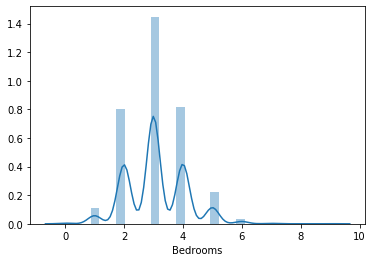

+--------+---------------+
|Bedrooms|bedrooms_bucket|
+--------+---------------+
|       9|            5.0|
|       8|            5.0|
|       7|            5.0|
|       7|            5.0|
|       7|            5.0|
|       7|            5.0|
|       6|            5.0|
|       6|            5.0|
|       6|            5.0|
|       6|            5.0|
|       6|            5.0|
|       6|            5.0|
|       6|            5.0|
|       6|            5.0|
|       6|            5.0|
+--------+---------------+
only showing top 15 rows



In [93]:
from pyspark.ml.feature import Bucketizer

# Plot distribution of sample_df 
sns.distplot(sample_df['Bedrooms'], axlabel='Bedrooms')
plt.show()

# Create the bucket splits and bucketizer
splits = [0, 1, 2, 3, 4, 5, float('Inf')]
buck = Bucketizer(splits=splits, inputCol='Bedrooms', outputCol='bedrooms_bucket')

# Apply the transformation to df and verify results
buck.transform(df)[['Bedrooms', 'bedrooms_bucket']].sort(col('Bedrooms').desc()).show(15)

<h3> One Hot Encoding </h3>


One Hot Encoding is a great way to handle categorial variables. You may notice after running the chunk below that the implementation in PySpark is different than Pandas get_dummies() as it puts everything into a single column of type vector rather than a new column for each value. It's also different from sklearn's OneHotEncoder in that the last categorical value is captured by a vector of all zeros.

In [96]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# Map strings to numbers with string indexer
string_indexer = StringIndexer(inputCol='SchoolDistrictNumber', outputCol='School_Index')
indexed_df = string_indexer.fit(df).transform(df)

# Onehot encode indexed values
encoder = OneHotEncoder(inputCol='School_Index', outputCol='School_Vec')
encoder.transform(indexed_df)[['SchoolDistrictNumber', 'School_Index', 'School_Vec']].show(truncate=100)

+-----------------------------+------------+-------------+
|         SchoolDistrictNumber|School_Index|   School_Vec|
+-----------------------------+------------+-------------+
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(7,[1],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(7,[1],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0])|
|             834 - Stillwater|         3.0|(7,[3],[1.0]

<h3> Model Selection </h3>


Phew, with all that feature engineering behind us, it's now time to consider how those engineered features can be incorporated into a machine learning model. The first step in training a model is to make an informed decision as to what model(s) is/are the most appropriate for the data at hand and the question being asked of the data. In this guide, the running theme has been to predict the price of a house. For that kind of quantity (i.e. $$) prediction, we'll want to use methods from Spark ml.regression. Standard linear, generalized linear, or or isotonic regression models are available, but the dataset we are working with doesn't exactly satisfy the assumptions of those models. Instead, we'll turn to some tree base approaches - Random Forest and GBTRegression for this task.

<h3> Train test split on date </h3>


As with any machine learning modeling process, it's best to first split the data into training and testing (and perhaps also validation) splits.

In [97]:
from datetime import timedelta

# Here we will write a function to split the dataset into a train and 
# test split based on the number of days from the most recent date
# in the dataset

def train_test_split_date(df, split_col, test_days=45):
  """Calculate the date to split test and training sets"""
  # Find how many days our data spans
  max_date = df.agg({split_col: 'max'}).collect()[0][0]
  min_date = df.agg({split_col: 'min'}).collect()[0][0]
  # Subtract an integer number of days from the last date in dataset
  split_date = max_date - timedelta(days=test_days)
  return split_date

# Find the date to use in spitting test and train
split_date = train_test_split_date(df, 'OFFMARKETDATE')

# Create Sequential Test and Training Sets
train_df = df.where(df['OFFMARKETDATE'] < split_date) 
test_df = df.where(df['OFFMARKETDATE'] >= split_date).where(df['LISTDATE'] <= split_date) 

print(test_df.count()) # maybe not the most reasonable split here, but you get the idea
print(train_df.count())


# Here are the dates from the train/test sorted by recency
print('Train df:')
train_df[['OFFMARKETDATE']].sort(col('OFFMARKETDATE')).show(10)
print(train_df.agg({'OFFMARKETDATE': 'min'}).collect()[0][0])
print(train_df.agg({'OFFMARKETDATE': 'max'}).collect()[0][0])

print('Test df:')
test_df[['OFFMARKETDATE']].sort(col('OFFMARKETDATE')).show(10)
print(test_df.agg({'OFFMARKETDATE': 'min'}).collect()[0][0])
print(test_df.agg({'OFFMARKETDATE': 'max'}).collect()[0][0])

154
4828
Train df:
+-------------------+
|      OFFMARKETDATE|
+-------------------+
|2017-02-24 00:00:00|
|2017-02-25 00:00:00|
|2017-02-27 00:00:00|
|2017-02-28 00:00:00|
|2017-03-02 00:00:00|
|2017-03-02 00:00:00|
|2017-03-03 00:00:00|
|2017-03-03 00:00:00|
|2017-03-03 00:00:00|
|2017-03-03 00:00:00|
+-------------------+
only showing top 10 rows

2017-02-24 00:00:00
2017-12-09 00:00:00
Test df:
+-------------------+
|      OFFMARKETDATE|
+-------------------+
|2017-12-10 00:00:00|
|2017-12-10 00:00:00|
|2017-12-11 00:00:00|
|2017-12-11 00:00:00|
|2017-12-11 00:00:00|
|2017-12-11 00:00:00|
|2017-12-11 00:00:00|
|2017-12-11 00:00:00|
|2017-12-11 00:00:00|
|2017-12-11 00:00:00|
+-------------------+
only showing top 10 rows

2017-12-10 00:00:00
2018-01-24 00:00:00


In [98]:
# We might be more concerned to simply create an 80/20 split
# based on the dates present in the available data. We'll 
# take that approach here. This approach takes the most 
# recent 20% of days in the test split. 

# First step is to create a column to rank the dates that homes were 
# taken off the market
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window

df = df.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("OFFMARKETDATE")))

# Now we can use that rank to split into a train/test
# Here we want the test set to be the most recent days, 
# so rank will be greater than 80%
test_df = df.where("rank >= .8").drop("rank")
train_df = df.where("rank < .8").drop("rank")

# Just to see how the rank approach taken above works
df[['OFFMARKETDATE', 'rank']].sort(col('rank').desc()).show(15)
df[['OFFMARKETDATE', 'rank']].sort(col('rank')).show(15)

+-------------------+------------------+
|      OFFMARKETDATE|              rank|
+-------------------+------------------+
|2018-01-24 00:00:00|0.9997999599919984|
|2018-01-24 00:00:00|0.9997999599919984|
|2018-01-22 00:00:00|0.9995999199839968|
|2018-01-19 00:00:00|0.9993998799759952|
|2018-01-18 00:00:00| 0.998999799959992|
|2018-01-18 00:00:00| 0.998999799959992|
|2018-01-17 00:00:00|0.9985997199439888|
|2018-01-17 00:00:00|0.9985997199439888|
|2018-01-16 00:00:00| 0.997999599919984|
|2018-01-16 00:00:00| 0.997999599919984|
|2018-01-16 00:00:00| 0.997999599919984|
|2018-01-15 00:00:00|0.9975995199039808|
|2018-01-15 00:00:00|0.9975995199039808|
|2018-01-12 00:00:00|0.9973994798959792|
|2018-01-10 00:00:00| 0.996999399879976|
+-------------------+------------------+
only showing top 15 rows

+-------------------+--------------------+
|      OFFMARKETDATE|                rank|
+-------------------+--------------------+
|2017-02-24 00:00:00|                 0.0|
|2017-02-25 00:00:00|2.

In [99]:
# Here are the dates from the train/test sorted by recency
print('Train df:')
train_df[['OFFMARKETDATE']].sort(col('OFFMARKETDATE')).show(10)
print(train_df.agg({'OFFMARKETDATE': 'min'}).collect()[0][0])
print(train_df.agg({'OFFMARKETDATE': 'max'}).collect()[0][0])

print('')
print('Test df:')
test_df[['OFFMARKETDATE']].sort(col('OFFMARKETDATE')).show(10)
print(test_df.agg({'OFFMARKETDATE': 'min'}).collect()[0][0])
print(test_df.agg({'OFFMARKETDATE': 'max'}).collect()[0][0])

Train df:
+-------------------+
|      OFFMARKETDATE|
+-------------------+
|2017-02-24 00:00:00|
|2017-02-25 00:00:00|
|2017-02-27 00:00:00|
|2017-02-28 00:00:00|
|2017-03-02 00:00:00|
|2017-03-02 00:00:00|
|2017-03-03 00:00:00|
|2017-03-03 00:00:00|
|2017-03-03 00:00:00|
|2017-03-03 00:00:00|
+-------------------+
only showing top 10 rows

2017-02-24 00:00:00
2017-10-09 00:00:00

Test df:
+-------------------+
|      OFFMARKETDATE|
+-------------------+
|2017-10-10 00:00:00|
|2017-10-10 00:00:00|
|2017-10-10 00:00:00|
|2017-10-10 00:00:00|
|2017-10-10 00:00:00|
|2017-10-10 00:00:00|
|2017-10-10 00:00:00|
|2017-10-10 00:00:00|
|2017-10-10 00:00:00|
|2017-10-10 00:00:00|
+-------------------+
only showing top 10 rows

2017-10-10 00:00:00
2018-01-24 00:00:00


<h3> Adjusting the time feature to reflect known information </h3>


Leaking information to your model during training can be dangerous. Data leakage will cause your model to have very optimistic metrics for accuracy but once real data is run through it the results are often very disappointing.
In the chunk below, we are going to ensure that DAYSONMARKET only reflects known information at the time of predicting the value. I.e., if the house is still on the market, we don't know how many more days it will stay on the market. We need to adjust our test_df to reflect what information we currently have as of 2017-10-10.
This is necessary because the number of days that a house has been listed on the market is most definitely going to have an impact on its final price (and therefore be a sensitive feature for our model). Homes that get snatched up quickly are more likely to be priced and sold at or above market rates while homes that linger on the market are likely to see price reductions and go for below market rates once they finally get sold.

In [100]:
from pyspark.sql.functions import datediff, to_date, lit

split_date = to_date(lit('2017-10-10')) # earliest date in the 80/20 train/test split
# Create Sequential Test set - to simulate 'real world' data where the off market date is unknown
# After all, what use is a home price prediction model for homes that have already been sold?
test_df = df.where(df['OFFMARKETDATE'] >= split_date).where(df['LISTDATE'] <= split_date)

# Create a copy of DAYSONMARKET to review later
test_df = test_df.withColumn('DAYSONMARKET_Original', test_df['DAYSONMARKET'])

# Recalculate DAYSONMARKET from what we know on our split date - '2017-10-10'
# I.e. we cannot allow our model to peer into the future and know when properties
# will go off market when testing the model against simulated 'real-world' data
test_df = test_df.withColumn('DAYSONMARKET', datediff(split_date, 'LISTDATE'))

# Review the difference
test_df[['LISTDATE', 'OFFMARKETDATE', 'DAYSONMARKET_Original', 'DAYSONMARKET']]\
                                                            .sort(col('LISTDATE').desc()).show()

+----------+-------------------+---------------------+------------+
|  LISTDATE|      OFFMARKETDATE|DAYSONMARKET_Original|DAYSONMARKET|
+----------+-------------------+---------------------+------------+
|2017-10-10|2017-11-14 00:00:00|                   19|           0|
|2017-10-10|2017-10-10 00:00:00|                    0|           0|
|2017-10-10|2017-11-10 00:00:00|                   31|           0|
|2017-10-10|2017-10-16 00:00:00|                    5|           0|
|2017-10-10|2017-11-18 00:00:00|                   39|           0|
|2017-10-10|2017-10-24 00:00:00|                    2|           0|
|2017-10-10|2017-10-16 00:00:00|                    6|           0|
|2017-10-10|2017-11-09 00:00:00|                   30|           0|
|2017-10-09|2017-11-02 00:00:00|                   24|           1|
|2017-10-09|2017-10-13 00:00:00|                    4|           1|
|2017-10-09|2017-11-22 00:00:00|                   22|           1|
|2017-10-09|2017-10-30 00:00:00|                

<h3> Final considerations before running a PySpark ML model </h3>

After doing a lot of feature engineering it's a good idea to take a step back and look at what you've created. If you've used some automation techniques on your categorical features like exploding or OneHot Encoding you may find that you now have hundreds of new binary features. While the subject of feature selection is material for a whole other guide, there are some quick steps you can take to reduce the dimensionality of your data set.


We'll start by dropping columns with less than 30 observations. Why 30? Well, 30 is a common minimum number of observations for statistical significance. Any less than that and the relationships can cause overfitting because of a sheer coincidence!

<h4> Think about bringing in external data </h4>


External data can often be the difference between a good model and a great model. For home sales price, it might be worthwhile to consider data such as mortgage rates, the walk/bike score of a house, the potential for solar panels or geothermal heating, seasonal indicators such as bank holidays or considerations of the time of the year that a home is listed (e.g. changes from mean/median home value for a given month/quarter/season compared to the entire year), etc.


<h4> Make sure your data fulfill the chosen models assumptions </h4>

This is a no brainer, but bares repeating - if the model you choose to use comes with assumptions, run some tests to ensure your data satisfy those assumptions.


<h4> PySpark ML vectors </h4>

Just to add one extra layer of complexity when using Spark, the PySpark machine learning algorithms require all features to be provided in a single column as a vector. Luckily, there is a fit/transform function provided to handle that, but it can also affect whether or not your features are truly ready for modeling. For example, while random forest regression can handle missing values, vectors cannot - so we need to assign missings/NaNs to a value outside the range of the values in the feature such that those observations can still be included but satisfy requirements for vectorization of all of the columns into one.
For our running example, most columns are strings which are not supported by vectors. <span style="color:red"><b> Since the focus of this guide is on feature engineering and not modeling, per se, those features will simply be dropped. </b> </span>


<h4> First, remove features based on missing value threshold </h4>

This is for binary (0/1) features.


<b> The code chunk below is commented out because it will simply throw an error - I did not include all of the binary features into the df </b>

In [101]:
## If you end up with a bunch of binary features, you can make sure to include only
#  those that have at least 30 positive values (e.g. 1's) with the code below

#obs_threshold = 30
#cols_to_remove = list()

# Inspect first 10 binary columns in list
#for col in binary_cols[0:10]:
  # Count the number of 1 values in the binary column
#  obs_count = df.agg({col: 'sum'}).collect()[0][0]
  # If less than our observation threshold, remove
#  if obs_count < obs_threshold:
#    cols_to_remove.append(col)
    
# Drop columns and print starting and ending dataframe shapes
#new_df = df.drop(*cols_to_remove)

<h3> Prepare data for vectorization </h3> 

In [102]:
# Replace missing values
train_df = train_df.fillna(-1)
test_df = test_df.fillna(-1)

# Have to naively remove all string columns for the vectorizer
string_cols = []
for col in range(1, len(train_df.columns)):
    if train_df.dtypes[col][1] == 'string':
        string_cols.append(train_df.dtypes[col][0])
        
train_df_for_vec = train_df.drop(*string_cols)
train_df_for_vec = train_df_for_vec.drop(*['LISTDATE', 'OFFMARKETDATE', 'MLSID', 'garage_list'])

test_df_for_vec = test_df.drop(*string_cols)
test_df_for_vec = test_df_for_vec.drop(*['LISTDATE', 'OFFMARKETDATE', 'MLSID', 'garage_list'])

# Define columns to be converted to vectors for model
feature_cols = list(train_df_for_vec.columns)

# Remove the dependent variable from the list
feature_cols.remove('SalesClosePrice')


<h4> Turn all features into a single feature vector</h4>

In [103]:
from pyspark.ml.feature import VectorAssembler

# Create the vector assembler transformer
vec = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Apply the vector transformer to data
train_df_vec = vec.transform(train_df_for_vec)
test_df_vec = vec.transform(test_df_for_vec)

<h3> Train some regression models </h3>

In [107]:
from pyspark.ml.regression import GBTRegressor

# Train a Gradient Boosted Trees (GBT) model.
gbt = GBTRegressor(featuresCol='features',
                           labelCol='SalesClosePrice',
                           predictionCol="Prediction_Price",
                           seed=42
                           )

# Train model.
gbt_model = gbt.fit(train_df_vec)

# Make predictions
gbt_predictions = gbt_model.transform(test_df_vec)

# Assess predictions
gbt_predictions.select('Prediction_Price', 'SalesClosePrice').show(10)

+------------------+---------------+
|  Prediction_Price|SalesClosePrice|
+------------------+---------------+
| 206190.2204954861|         190000|
|271449.81040652894|         250000|
|279839.33081246796|         274000|
| 347496.3512089177|         320000|
| 327280.7535827308|         310000|
| 406852.9213633721|         394900|
| 425790.5114662232|         404005|
|437878.45020259457|         415000|
| 399828.1704818597|         405000|
| 445967.6172403549|         427878|
+------------------+---------------+
only showing top 10 rows



In [106]:
from pyspark.ml.regression import RandomForestRegressor

# Train a Gradient Boosted Trees (GBT) model.
rf = RandomForestRegressor(featuresCol='features',
                           labelCol='SalesClosePrice',
                           predictionCol="Prediction_Price",
                           seed=42
                           )

# Train model.
rf_model = rf.fit(train_df_vec)

# Make predictions
rf_predictions = rf_model.transform(test_df_vec)

# Assess predictions
rf_predictions.select('Prediction_Price', 'SalesClosePrice').show(10)

+------------------+---------------+
|  Prediction_Price|SalesClosePrice|
+------------------+---------------+
|211932.78181187768|         190000|
|275671.51147754636|         250000|
| 285690.8598870293|         274000|
|352221.98685206973|         320000|
| 312622.5227735326|         310000|
|421016.02356793184|         394900|
| 425221.3548506096|         404005|
| 430171.1539543176|         415000|
|417483.15330849536|         405000|
| 428138.5526917122|         427878|
+------------------+---------------+
only showing top 10 rows



<h3> Model evaluation </h3>


Even though this is a guide about feature engineering, I actually incorporated very minimal feature engineering into the final data fed into the regression models. Nevertheless, and perhaps surprisingly, the models both tend to perform quite well right out of the box. Depending on the business context, these models might be sufficient, but certainly the methods described above would be able to push model performance much higher.

In [108]:
from pyspark.ml.evaluation import RegressionEvaluator

# Select columns to compute test error
evaluator = RegressionEvaluator(labelCol='SalesClosePrice', 
                                predictionCol='Prediction_Price')
# Dictionary of model predictions to loop over
models = {'Gradient Boosted Trees': gbt_predictions, 'Random Forest Regression': rf_predictions}
for key, preds in models.items():
  # Create evaluation metrics
  rmse = evaluator.evaluate(preds, {evaluator.metricName: 'rmse'})
  r2 = evaluator.evaluate(preds, {evaluator.metricName: 'r2'})
  
  # Print Model Metrics
  print(key + ' RMSE: ' + str(rmse))
  print(key + ' R^2: ' + str(r2))

Gradient Boosted Trees RMSE: 34011.12279793935
Gradient Boosted Trees R^2: 0.9450420831384192
Random Forest Regression RMSE: 38045.79868837645
Random Forest Regression R^2: 0.9312295707422336


In [109]:
# Convert feature importances to a pandas column - no need to use Spark with such small dataframes
gbt_fi_df = pd.DataFrame(gbt_model.featureImportances.toArray(), columns=['importance'])
rf_fi_df = pd.DataFrame(rf_model.featureImportances.toArray(), columns=['importance'])

In [110]:
# Convert list of feature names to pandas column
gbt_fi_df['feature'] = pd.Series(feature_cols)

# Sort the data based on feature importance
gbt_fi_df.sort_values(by=['importance'], ascending=False, inplace=True)

# Inspect Results
gbt_fi_df.head(10)

,importance,feature
2,0.192304,LISTPRICE
4,0.149841,PricePerTSFT
6,0.068322,DAYSONMARKET
10,0.056712,Taxes
8,0.054845,PDOM
0,0.054831,StreetNumberNumeric
13,0.050748,LivingArea
32,0.036363,BATHS_PER_1000SQFT
9,0.030437,SQFTABOVEGROUND
7,0.028048,Fireplaces


In [111]:
# Convert list of feature names to pandas column
rf_fi_df['feature'] = pd.Series(feature_cols)

# Sort the data based on feature importance
rf_fi_df.sort_values(by=['importance'], ascending=False, inplace=True)

# Inspect Results
rf_fi_df.head(10)

,importance,feature
2,0.407622,LISTPRICE
3,0.205262,OriginalListPrice
13,0.104483,LivingArea
31,0.077313,Total_SQFT
9,0.058190,SQFTABOVEGROUND
10,0.047772,Taxes
21,0.022969,BATHSTOTAL
4,0.020604,PricePerTSFT
0,0.013830,StreetNumberNumeric
22,0.006575,Bedrooms


<h3> Save and load the models </h3>

In [112]:
# Save the models 
gbt_model.save('house_price_regression_gbt_model')
rf_model.save('house_price_regression_rf_model')

In [113]:
from pyspark.ml.regression import RandomForestRegressionModel

# Load the model
rf_model_loaded = RandomForestRegressionModel.load('house_price_regression_rf_model')

References

1) https://github.com/ajupton/PySpark_guides/blob/master/Feature%20Engineering%20with%20PySpark.ipynb